MAnorm2 1.2.0 2021-09-10

Loading required package: limma

Registering fonts with R



During the local regression procedure:
After iteration 1: 2 (0.00%) outlier(s) detected
After iteration 2: 4 (0.00%) outlier(s) detected
After iteration 3: 4 (0.00%) outlier(s) detected
Converged.



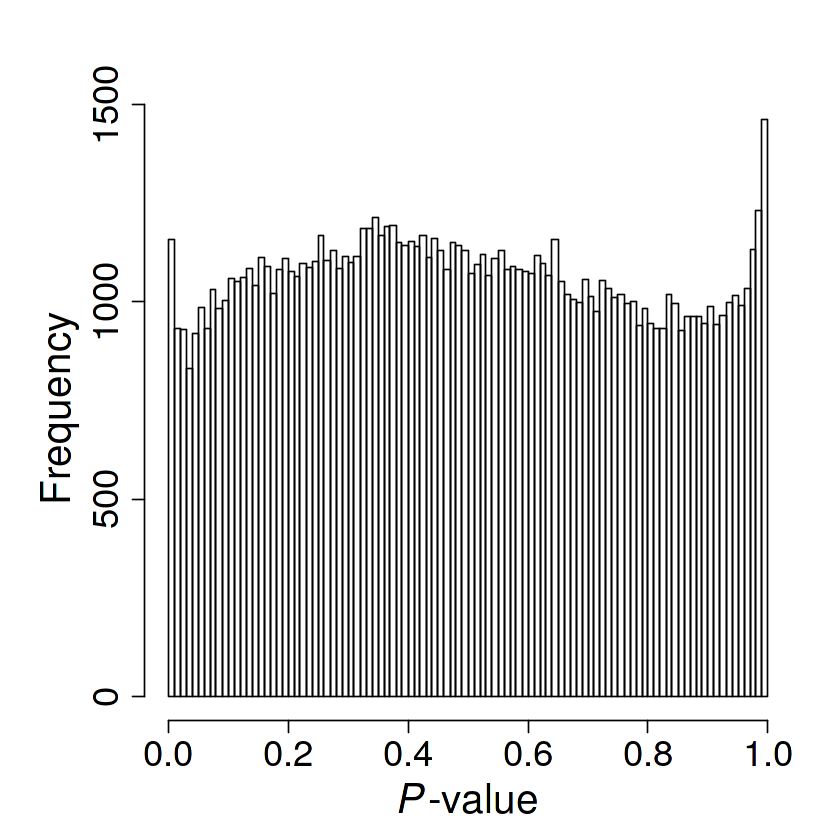

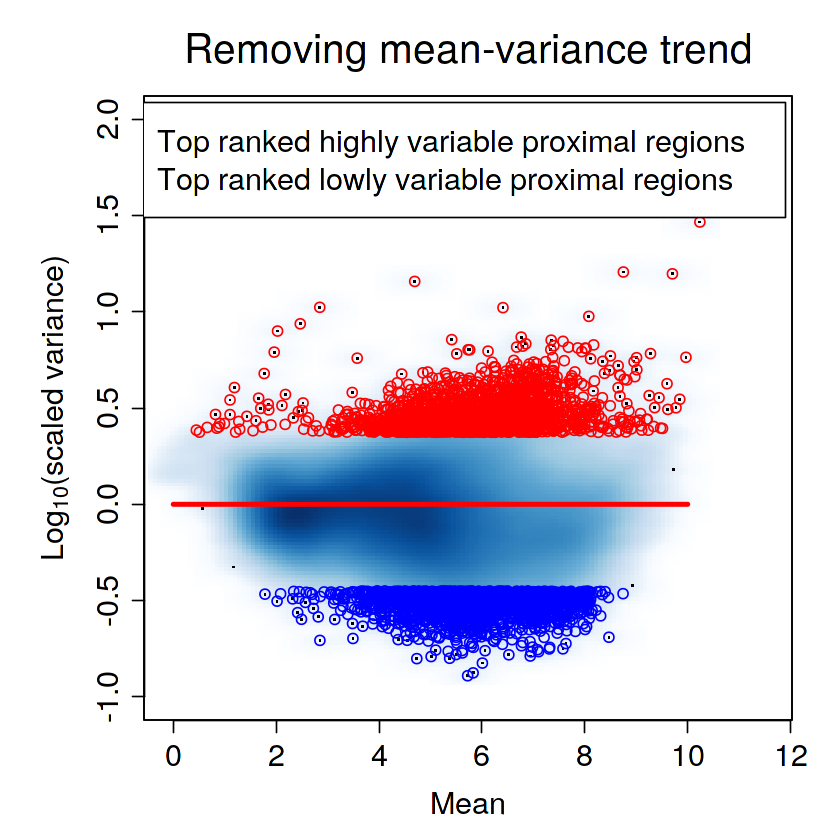

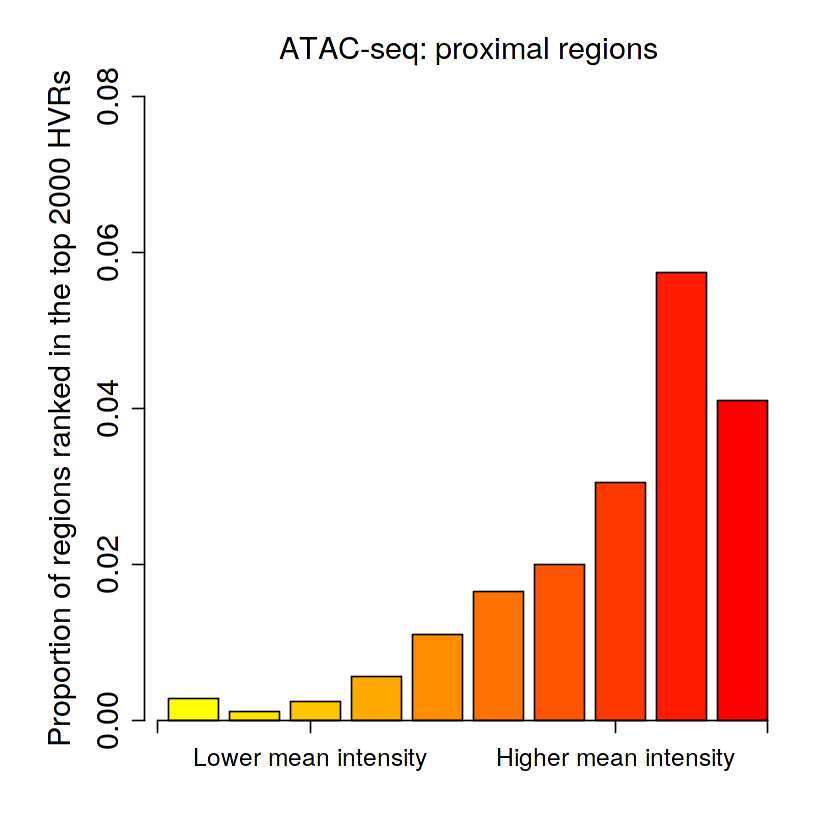

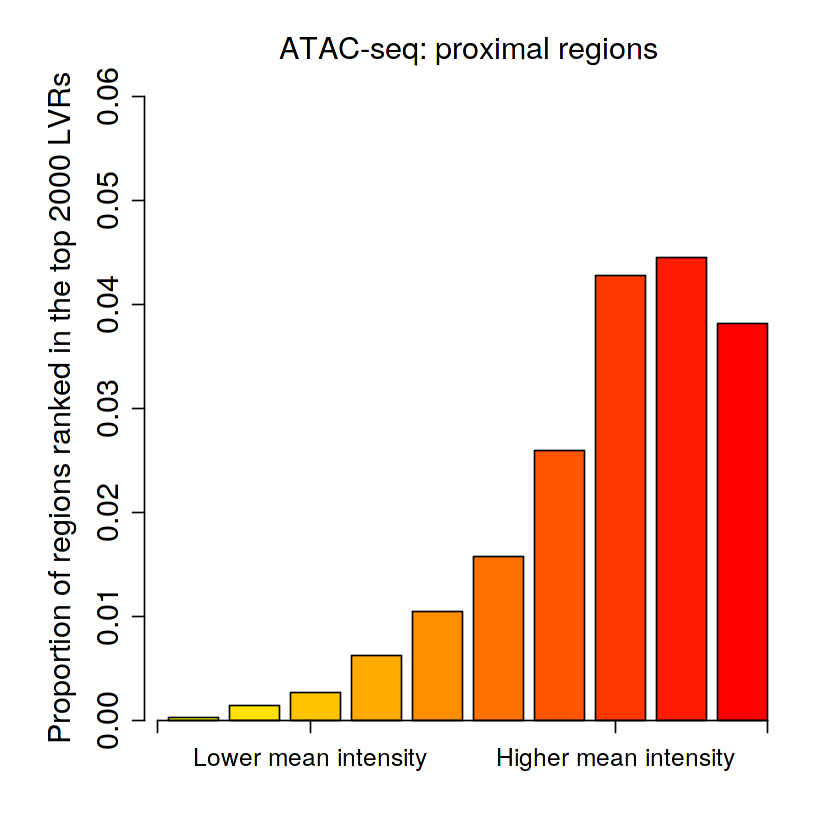

In [1]:
#import MAnorm2 packages
library(MAnorm2)
library(statmod)
library(scales)
library(RColorBrewer)
library(edgeR)
library(preprocessCore)
library(extrafont)

#calculate single end p-value
single.end.pvalue<-function(biocond){
    df<-attr(biocond,"df")
    p.value<-pf(biocond$fold.change,df[1],df[2],lower.tail=F)
    return(p.value)
}

mypalette<-colorRampPalette(c("yellow",'red'))
mycolors<-mypalette(10)

num.of.bins<-10
num.of.peaks<-2000

path<-'/media/chenhaojie/shao_lab_Disk02/Data_set_used_in_MAnorm2_and_HyperChIP/Hyper_variable_peaks/New/5kb/ATAC/proximal_peaks_5kb.txt'

reads_count<-c(4,c(6:9),c(11:39))
occupancy<-c(40,c(42:45),c(47:75))

raw_reads_count<-read.table(path,header=T,sep='\t')
raw_reads_count<-raw_reads_count[rowSums(raw_reads_count[occupancy])>0,]

normalized.data<-MAnorm2::normalize(raw_reads_count,reads_count,occupancy,offset=0.5,
                                    baseline='pseudo-reference')

biocond<-bioCond(normalized.data[reads_count],
                 normalized.data[occupancy],
                 occupy.num=1,name='Tumor')


conds.list<-list(biocond)

method<-'loc'
conds.list.fit<-fitMeanVarCurve(conds.list,method=method,occupy.only=F,args.lp=list(nn=1.0))

conds.fit.var<-varTestBioCond(conds.list.fit[[1]])
p.values<-single.end.pvalue(conds.fit.var)
p.values2<-1-p.values

#------------------------------------------------------------
#Figure4C
#------------------------------------------------------------

par(mar=c(5,6,4,2),cex.main=1,font.main=1)
hist(p.values,breaks=100,
     main='',
     cex.lab=2,cex.axis=1.8,cex.main=2,cex=1.5,xlab=expression(paste(italic(P),"-value")))



par(mar=c(5,6,4,2))
smoothScatter(conds.fit.var$observed.mean,
              log10(conds.fit.var$fold.change*conds.list.fit[[1]]$fit.info$ratio.var),
              xlab='Mean',ylab=expression(paste(Log[10],"(scaled variance)")),cex.lab=1.5,cex=1.5,cex.axis=1.5,
              main='Removing mean-variance trend',cex.main=2,ylim=c(-1,2))


lines(c(0,10),c(0,0),col='red',lwd=3)

points(conds.fit.var$observed.mean[c(rank(p.values)<num.of.peaks)],
       log10(conds.fit.var$fold.change*conds.list.fit[[1]]$fit.info$ratio.var)[c(rank(p.values)<num.of.peaks)],col='red')
points(conds.fit.var$observed.mean[c(rank(p.values2)<=num.of.peaks)],
       log10(conds.fit.var$fold.change*conds.list.fit[[1]]$fit.info$ratio.var)[c(rank(p.values2)<=num.of.peaks)],col='blue')

legend('topright',c('Top ranked highly variable proximal regions',
                    'Top ranked lowly variable proximal regions'),
       inset=0.01,
       pch=21,
       col=c('red','blue'),cex=1.5)

#------------------------------------------------------------
#Supplementary Figure3A
#------------------------------------------------------------

a<-list()
for(i in c(1:num.of.bins)){
    a<-append(sum(c(rank(p.values)<num.of.peaks)&c(conds.fit.var$observed.mean<=quantile(conds.fit.var$observed.mean,i/num.of.bins))&
                               c(conds.fit.var$observed.mean>quantile(conds.fit.var$observed.mean,(i-1)/num.of.bins)))/sum(c(conds.fit.var$observed.mean<=quantile(conds.fit.var$observed.mean,i/num.of.bins))&
                               c(conds.fit.var$observed.mean>quantile(conds.fit.var$observed.mean,(i-1)/num.of.bins))),a)
}


par(mar=c(5,6,4,2),cex.main=1,font.main=1)
barplot(as.numeric(a)[c(num.of.bins:1)],main='ATAC-seq: proximal regions',
        col=mycolors,cex.axis=1.5,ylim=c(0,0.08),ylab='Proportion of regions ranked in the top 2000 HVRs',cex.main=1.5,cex.lab=1.5)
axis(side=1,at=c(0,3,9,12),labels=c('','Lower mean intensity','Higher mean intensity',''),cex.axis=1.2)




#------------------------------------------------------------
#Supplementary Figure3B
#------------------------------------------------------------

a<-list()
for(i in c(1:num.of.bins)){
    a<-append(sum(c(rank(p.values2)<=num.of.peaks)&c(conds.fit.var$observed.mean<=quantile(conds.fit.var$observed.mean,i/num.of.bins))&
                               c(conds.fit.var$observed.mean>quantile(conds.fit.var$observed.mean,(i-1)/num.of.bins)))/sum(c(conds.fit.var$observed.mean<=quantile(conds.fit.var$observed.mean,i/num.of.bins))&
                               c(conds.fit.var$observed.mean>quantile(conds.fit.var$observed.mean,(i-1)/num.of.bins))),a)
}


par(mar=c(5,6,4,2),cex.main=1,font.main=1)
barplot(as.numeric(a)[c(num.of.bins:1)],main='ATAC-seq: proximal regions',
        col=mycolors,cex.axis=1.5,ylim=c(0,0.06),cex.main=1.5,ylab='Proportion of regions ranked in the top 2000 LVRs',cex.lab=1.5)
axis(side=1,at=c(0,3,9,12),labels=c('','Lower mean intensity','Higher mean intensity',''),cex.axis=1.2)



